In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd

In [11]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [13]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [20]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Percipitation (in)')

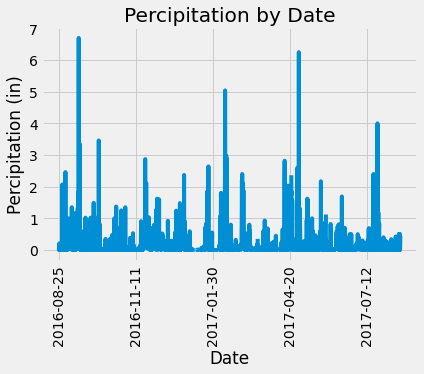

In [244]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

date = dt.datetime(2016, 8, 24)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date > date)\
    .order_by(Measurement.date.asc())\
    .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(results, columns=['date', 'percipitation'])
last_year_df.set_index('date', inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = last_year_df.plot(legend = False, rot=90)
ax.set_title("Percipitation by Date")
ax.set_xlabel("Date")
ax.set_ylabel("Percipitation (in)")

In [65]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,percipitation
count,2009.000000
mean,0.172344
std,0.452818
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [250]:
# Design a query to show how many stations are available in this dataset
len(session.query(Measurement.station.distinct()).all())

9

In [82]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [252]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
average_t = session.query(func.avg(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281')\
    .all()

max_t = session.query(func.max(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281')\
    .all()

min_t = session.query(func.min(Measurement.tobs))\
    .filter(Measurement.station == 'USC00519281')\
    .all()

print('AVG:', average_t[0][0])
print('MAX:', max_t[0][0])
print('MIN:', min_t[0][0])

AVG: 71.66378066378067
MAX: 85.0
MIN: 54.0


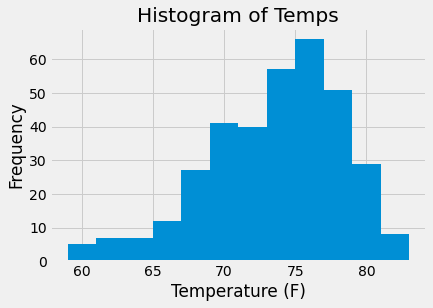

In [281]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result = session.query(Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date > date)\
    .all()

result = [x[0] for x in result]

plt.hist(result, bins = 12)
plt.title('Histogram of Temps')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [254]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [255]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.datetime(2016, 12, 12)
trip_end = dt.datetime(2016, 12, 31)

trip_data = calc_temps(trip_start, trip_end)
trip_data

[(60.0, 71.1951219512195, 78.0)]

Text(0, 0.5, 'Temp (F)')

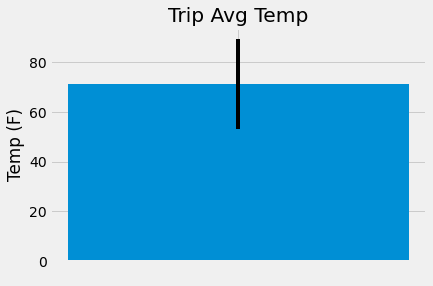

In [284]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(' ', trip_data[0][1], yerr = (trip_data[0][2] - trip_data[0][0]))
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')

In [224]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

stations = []
precipitation = []
lat = []

for i in session.query(Measurement.station.distinct()).all():
    stations.append(i[0])
    precip = session.query(func.sum(Measurement.prcp))\
        .filter(Measurement.date >= trip_start)\
        .filter(Measurement.date <= trip_end)\
        .filter(Measurement.station == i[0])\
        .all()
    precipitation.append(precip[0][0])

conn = engine.connect()

df1 = pd.read_sql('SELECT * FROM station', conn)
df1
data = zip(stations, precipitation)
df2 = pd.DataFrame(data, columns=['station', 'precip'])
df2

merge_df = pd.merge(df1, df2, on = 'station')
merge_df = merge_df.sort_values('precip', ascending = False)
merge_df

,id,station,name,latitude,longitude,elevation,precip
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,10.74
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.24
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.67
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.11
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,1.18
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.47
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.06
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,NaN
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,NaN


In [225]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [232]:
dates_list = [f'12-{x+12}' for x in range(32-12)]
dates_list
normals = []

# calculate the daily normals for your trip
for date in dates_list:
    norm = daily_normals(date)
    normals.append(norm[0])

normals

[(64.0, 70.88235294117646, 79.0),
 (65.0, 70.9423076923077, 80.0),
 (65.0, 71.18, 78.0),
 (62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0),
 (61.0, 70.34693877551021, 78.0),
 (62.0, 70.0625, 78.0),
 (60.0, 71.75, 79.0),
 (63.0, 71.44680851063829, 77.0),
 (62.0, 71.91666666666667, 79.0),
 (62.0, 70.52083333333333, 77.0),
 (57.0, 70.29166666666667, 78.0),
 (63.0, 69.86363636363636, 76.0),
 (56.0, 68.27906976744185, 77.0)]

In [237]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df3 = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df3.head()

,tmin,tavg,tmax
0,64.0,70.882353,79.0
1,65.0,70.942308,80.0
2,65.0,71.180000,78.0
3,62.0,71.340000,79.0
4,60.0,69.622642,82.0


[Text(0, 0, '12-12'),
 Text(0, 0, '12-13'),
 Text(0, 0, '12-14'),
 Text(0, 0, '12-15'),
 Text(0, 0, '12-16'),
 Text(0, 0, '12-17')]

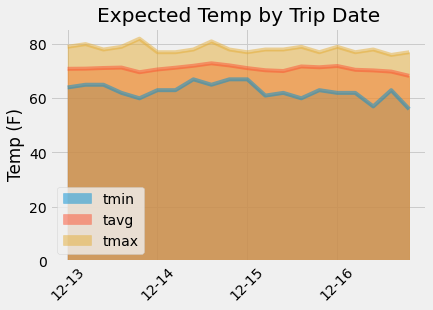

In [280]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df3.plot.area(stacked = False)
ax.set_title('Expected Temp by Trip Date')
ax.set_ylabel('Temp (F)')
ax.set_xticklabels(dates_list, rotation = 45)